In [2]:
import sys
if "/Users/raymond/code/FinalProject563" not in sys.path:
    sys.path.append("/Users/raymond/code/FinalProject563")
import torch
import pickle
import glob
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas
import time
import os

import connect_four
import mcts
import connect_net
import connect_plot
import evaluation
import utils
import runner
%matplotlib inline
%load_ext autoreload
%autoreload 2
os.chdir("/Users/raymond/code/FinalProject563")

In [100]:
trial = "conv402"
iteration = 65
training_path = utils.get_training_model_path(trial=trial, iteration=iteration)
nnet = connect_net.load_model(path=training_path, log=False, klass=connect_net.ConnectNet4)
# networks = {}
# for i in range(1, 64):
#     iteration = i
#     training_folder = utils.get_training_folder(trial=trial, iteration=iteration)
#     training_path = runner.get_model_path(folder=training_folder, iteration=iteration)
#     nnet = connect_net.load_model(path=training_path, log=False)
#     networks[i] = nnet
# nnetp = connect_net.load_model(path="models/pretrain01.model", log=False)
# networks["p"] = nnetp
# print(len(networks))

In [104]:
# strategy1 = evaluation.NetworkStrategy(nnet=nnet63, c=1/16, eps=1e-6, num_mcts_sims=32, random_moves=4)
# strategy2 = evaluation.NetworkStrategy(nnet=nnet63, c=1/8, eps=1e-6, num_mcts_sims=32, random_moves=4)
# strategy3 = evaluation.NetworkStrategy(nnet=nnet63, c=1/4, num_mcts_sims=32, random_moves=4)
# strategy4 = evaluation.NetworkStrategy(nnet=nnet63, c=1/2, num_mcts_sims=32, random_moves=4)
# strategy5 = evaluation.NetworkStrategy(nnet=nnet63, c=1, num_mcts_sims=32, random_moves=4)
# strategy6 = evaluation.NetworkStrategy(nnet=nnet63, c=2, eps=1e-6, num_mcts_sims=32, random_moves=4)
# strategy7 = evaluation.NetworkStrategy(nnet=nnet63, c=4, eps=1e-6, num_mcts_sims=32, random_moves=4)

strategy1 = evaluation.NetworkStrategy(nnet=nnet, c=1, num_mcts_sims=4, random_moves=8)
strategy2 = evaluation.NetworkStrategy(nnet=nnet, c=1, num_mcts_sims=8, random_moves=8)
strategy3 = evaluation.NetworkStrategy(nnet=nnet, c=1, num_mcts_sims=16, random_moves=8)
strategy4 = evaluation.NetworkStrategy(nnet=nnet, c=1, num_mcts_sims=32, random_moves=8)
strategy5 = evaluation.NetworkStrategy(nnet=nnet, c=1, num_mcts_sims=64, random_moves=8)
strategy6 = evaluation.NetworkStrategy(nnet=nnet, c=1, num_mcts_sims=128, random_moves=8)
strategy7 = evaluation.NetworkStrategy(nnet=nnet, c=1, num_mcts_sims=256, random_moves=8)

# strategy1 = evaluation.NetworkStrategy(nnet=nnet1, c=1, num_mcts_sims=32, random_moves=6)
# strategy2 = evaluation.NetworkStrategy(nnet=nnet51, c=1, num_mcts_sims=32, random_moves=6)

networks = {
    1: strategy1,
    2: strategy2,
    3: strategy3,
    4: strategy4,
    5: strategy5,
    6: strategy6,
    7: strategy7,
}
scores = {k: 1600 for k in networks.keys()}

In [105]:
fin_scores, df_all = evaluation.parallel_competition(
    scores=scores, strategies=networks, num_processes=6, num_games=100, k=16)

ITER::0  TIME::8.111
ITER::10  TIME::6.079
ITER::20  TIME::4.340
ITER::30  TIME::3.436
ITER::40  TIME::6.374
ITER::50  TIME::5.990
ITER::60  TIME::10.454
ITER::70  TIME::10.427
ITER::80  TIME::9.936
ITER::90  TIME::5.585


In [114]:
dft = df_all.copy()
dft["sims"] = 2**(dft["Player"].add(1))

In [119]:
dft.pivot("iteration", "sims", "ELO").iloc[-1]

sims
4      1529.065336
8      1570.860955
16     1595.161609
32     1605.579974
64     1624.367435
128    1632.342780
256    1642.621911
Name: 99, dtype: float64

<AxesSubplot:xlabel='sims'>

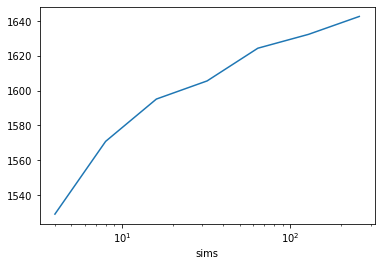

In [118]:
dft.pivot("iteration", "sims", "ELO").iloc[-1].plot(logx=True)

In [93]:
# conv501, blank01
results_folder = utils.get_results_folder(trial="conv402")
df_all = pandas.read_csv(os.path.join(results_folder, "all_scores.csv"))
df_fin = pandas.read_csv(os.path.join(results_folder, "fin_scores.csv"))
# df_all = df_all[df_all["Player"].le(72)]

Text(0.5, 1.0, 'ELO by Iteration')

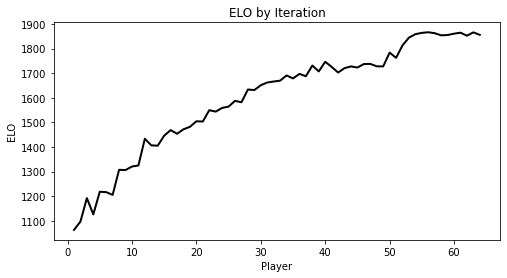

In [97]:
# df_all.pivot("iteration", "Player", "ELO").iloc[-500:].T.plot(figsize=(16, 8), legend=False)
df_all.pivot("iteration", "Player", "ELO").iloc[-1].plot(color="k", linewidth=2, figsize=(8,4))
plt.ylabel("ELO")
plt.title("ELO by Iteration")

<AxesSubplot:xlabel='iteration'>

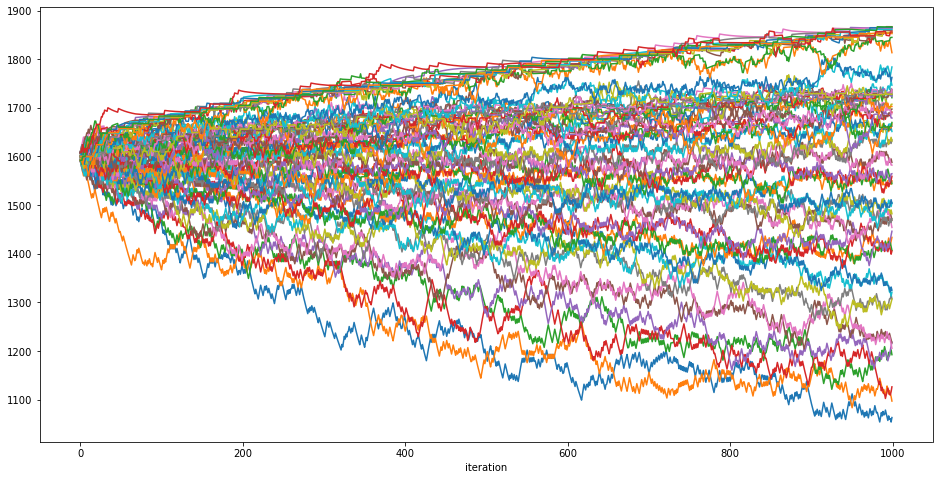

In [98]:
df_all.pivot("iteration", "Player", "ELO").plot(figsize=(16, 8), legend=False)

In [65]:
list_df = []
for file in glob.glob("data/trialconv402/training*/validation-avg-losses-*.pickle"):
    dft = pandas.DataFrame()
    with open(file, "rb") as f:
        dft["Losses"] = pickle.load(f)
    dft["epoch"] = int(file.split("/")[2][8:])
    dft = dft.reset_index().rename(columns={"index": "iteration"})
    list_df.append(dft)

64
0.9846159815788269


Text(0.5, 1.0, 'Traning Validation Losses')

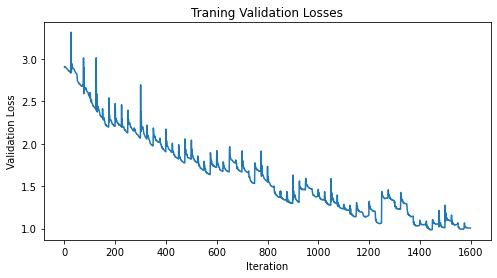

In [87]:
df = pandas.concat(list_df)
print(df["epoch"].max())
print(df["Losses"].min())
df["ai"] = df["epoch"].sub(1).mul(25).add(df["iteration"])
df.sort_values("ai").set_index("ai")["Losses"].plot(figsize=(8, 4))
plt.ylabel("Validation Loss")
plt.xlabel("Iteration")
plt.title("Traning Validation Losses")

In [84]:
start_state = connect_four.start_state()
data = {}
for file in glob.glob("data/trialconv402/training*/model-*.model"):
    num = int(file.split("/")[2][8:])
    nnet = connect_net.load_model(path=file, log=False, klass=connect_net.ConnectNet4)
    v, proba = nnet(start_state.view(1, 1, 6, 7))
    data[num] = proba[0].detach().numpy()
    v, proba = nnet(state_3.view(1, 1, 6, 7))
    data_3[num] = proba[0].detach().numpy()

Text(0.5, 0, 'Iteration')

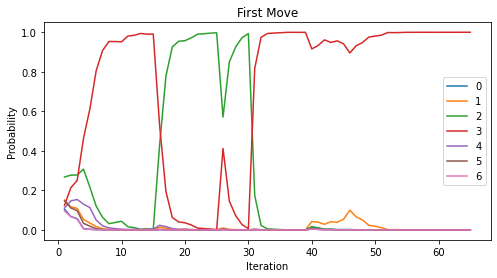

In [85]:
pandas.DataFrame(data).T.sort_index().plot(figsize=(8, 4))
plt.title("First Move")
plt.ylabel("Probability")
plt.xlabel("Iteration")

In [35]:
data_folder = utils.get_data_folder()
boards = np.load(os.path.join(data_folder, "move8_boards.npy"))
winners = np.load(os.path.join(data_folder, "move8_winner.npy"))
boards = torch.Tensor(boards)
winners = torch.Tensor(winners)

In [86]:
trial = "conv402"
list_df_402 = []
for file in glob.glob(f"data/trial{trial}/training*/model-*.model"):
    num = int(file.split("/")[2][8:])
    nnet = connect_net.load_model(path=file, log=False, klass=connect_net.ConnectNet4)
    v, proba = nnet(boards.view(-1,1,6,7))
    df8 = pandas.DataFrame()
    df8["pred"] = v.detach().numpy()
    df8["winners"] = winners.numpy()
    df8["nnet"] = num
    list_df_402.append(df8)

In [88]:
df402 = pandas.concat(list_df_402)
df402["diff"] = df402["winners"]-df402["pred"]
df402["sq_diff"] = np.square(df402["diff"])
df402["pred_round"] = df402["pred"].round()
df402["pred_sign"] = df402["pred"] >= 0
df402["eq"] = df402["pred_round"] == df402["winners"]
df402["eq_sign"] = df402["pred_sign"] == df402["winners"]

Text(0.5, 0, 'Iteration')

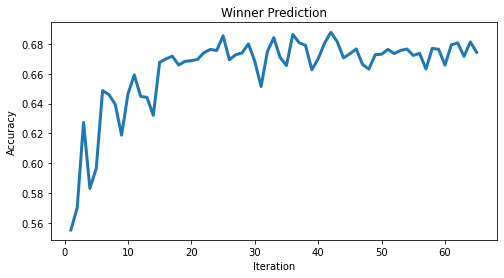

In [92]:
dfplot = df402[df402["winners"].ne(0)].groupby("nnet")["eq_sign"].mean()
dfplot.iloc[1] = 0.57
dfplot.plot(figsize=(8, 4), linewidth=3)
plt.title("Winner Prediction")
plt.ylabel("Accuracy")
plt.xlabel("Iteration")

In [32]:
trial = "conv401"

list_df_401 = []
for file in glob.glob(f"data/trial{trial}/training*/model-*.model"):
    num = int(file.split("/")[2][8:])
    nnet = connect_net.load_model(path=file, log=False, klass=connect_net.ConnectNet3)
    v, proba = nnet(boards.view(-1,1,6,7))
    df8 = pandas.DataFrame()
    df8["pred"] = v.detach().numpy()
    df8["winners"] = winners.numpy()
    df8["nnet"] = num
    list_df_401.append(df8)
    
trial = "conv402"
list_df_402 = []
for file in glob.glob(f"data/trial{trial}/training*/model-*.model"):
    num = int(file.split("/")[2][8:])
    nnet = connect_net.load_model(path=file, log=False, klass=connect_net.ConnectNet4)
    v, proba = nnet(boards.view(-1,1,6,7))
    df8 = pandas.DataFrame()
    df8["pred"] = v.detach().numpy()
    df8["winners"] = winners.numpy()
    df8["nnet"] = num
    list_df_402.append(df8)

In [33]:
df = pandas.concat(list_df)
df["diff"] = df["winners"]-df["pred"]
df["sq_diff"] = np.square(df["diff"])
df["pred_round"] = df["pred"].round()
df["pred_sign"] = df["pred"] >= 0
df["eq"] = df["pred_round"] == df["winners"]
df["eq_sign"] = df["pred_sign"] == df["winners"]
df = df[df["nnet"].le(72)]

Text(0.5, 0, 'Iteration')

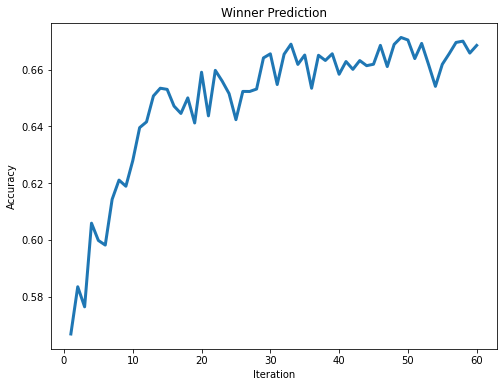

In [34]:
df[df["winners"].ne(0)].groupby("nnet")["eq_sign"].mean().plot(figsize=(8, 6), linewidth=3)
plt.title("Winner Prediction")
plt.ylabel("Accuracy")
plt.xlabel("Iteration")
# plt.axvline(70)